In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this notebook I would like the answer the question-
“what sorts of people were more likely to survive?”
using some classification models that predicts which passengers survived the Titanic shipwreck.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# **Importing the datasets**

## **Train data**

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **Test data**

In [4]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **Data Analysis**

### The train data contain information about 891 passengers (rows) and 14 columns.

In [5]:
train_data.shape

(891, 12)

### The type of each column in the data frame:

In [6]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Checking for missing data

In [7]:
# find the columns with Nans
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

There are three columns with Nan values.

Let's replace the Nans in the Age column by the mean of the column.

In [8]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # replace the nan by the mean of the column's values
imputer.fit(train_data[['Age']])
train_data['Age'] = imputer.transform(train_data[['Age']])

The Cabin column and the Embarked column are object types, so we'll replace the Nans by empty string ''.

In [9]:
train_data['Cabin'].replace(np.nan, '', inplace = True)
train_data['Embarked'].replace(np.nan, '', inplace = True)

Now we will ensure there are no Nan values anymore-

In [10]:
train_data.isnull().values.any()
train_data.columns[train_data.isna().any()].tolist()

[]

**Good! there are no Nans.**

There are no duplicates:

In [11]:
train_data.duplicated().any()

False

For the sake of convenience, we will encode the Sex column into a new column- Sex_cat, where 0 = female and 1 = male.

Additionally, we will create a new column, AgeGroup, that will contain the age groups of the passengers according the following partition:
- Infant: 0-3
- Kid: 4-12
- Teen: 13-19
- Adult: 20-110

In [12]:
train_data["Sex"] = train_data["Sex"].astype('category')
train_data["Sex_cat"] = train_data["Sex"].cat.codes

bins= [0,4,13,20,110]
labels = ['Infant','Kid','Teen','Adult']
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)
train_data.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
Sex_cat            int8
AgeGroup       category
dtype: object

In [13]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,1,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,0,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,1,Adult


### Some statistics information:

In [14]:
train_data.iloc[:, 1:].describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,AgeGroup
count,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,891,891,891.000000,891
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,148,4,NaN,4
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,,S,NaN,Adult
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,687,644,NaN,727
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,0.647587,NaN
std,0.486592,0.836071,NaN,NaN,13.002015,1.102743,0.806057,NaN,49.693429,NaN,NaN,0.477990,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN
25%,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN,NaN,0.000000,NaN
50%,0.000000,3.000000,NaN,NaN,29.699118,0.000000,0.000000,NaN,14.454200,NaN,NaN,1.000000,NaN
75%,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,1.000000,NaN


 #### According to the descriptive statistics table above-

**Survived:**
- Most of the passengers didn't survived (as we already know...), the mean = 0.3838 and the median = 0.

**Ticket Class (Pclass):**
- The mean = 2.3 and the median = 3, indicates that most tickets are for third class, and the minority are for first class.

**Sex**
- There are 577 male passengers and the rest are female.

**Age/AgeGroup**
- The average age is 29.699 and so the median, with a std of ~13. Most of the passengers are adults.

**Number of Siblings/Spouses (SibSp)**
- According to the mean and the median, most of the passengers came without their sibilig or spouses.

**Number of Parents/Children (Parch)**
- According to the mean and the median, most of the passengers came without their parents or children.

**Fare**
- It seems that most of the passengers paids for the trip below to 14.45 (A right skewed distribution, mean > median).

**Cabin**
- The mode of the cabin numer is unknown.

**Embarked**
- There three port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton. The common one is Southampton.

<AxesSubplot:>

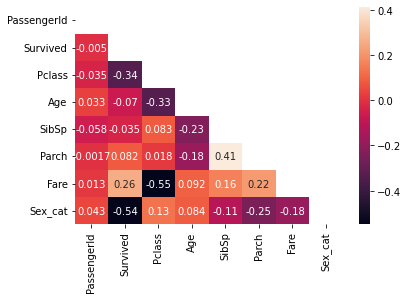

In [15]:
corr = train_data.corr()
mask = np.triu(np.ones_like(corr))

sns.heatmap(corr, mask = mask, annot = True)

We can see a moderately negative correlation between the Sex variable ( = Sex_cat) and the Survived variable.

### Data Visualization
Helps us to understand better how the data are behaving

Text(0.5, 1.0, 'Passenger fare')

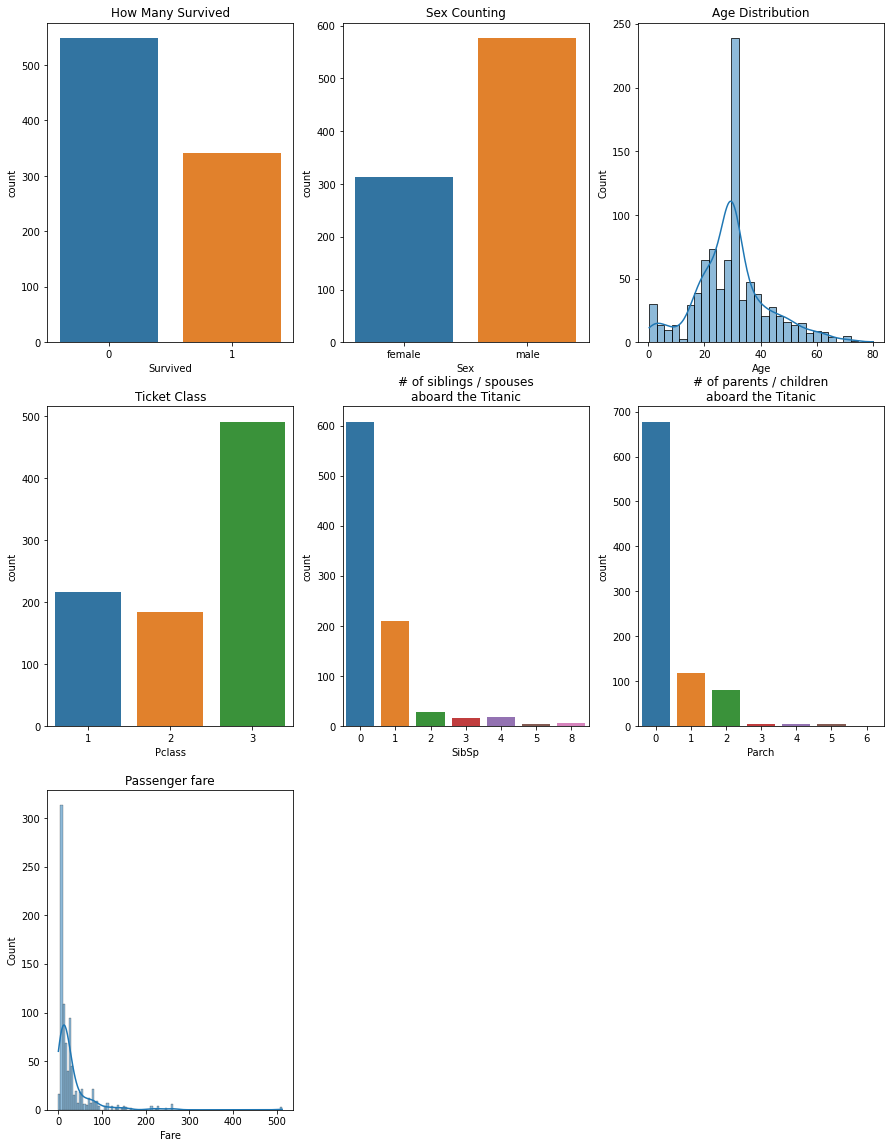

In [16]:
plt.figure(figsize = (15,20))

plt.subplot(3, 3, 1)
sns.countplot(x = 'Survived', data = train_data)
plt.title("How Many Survived")

plt.subplot(3, 3, 2)
sns.countplot(x = "Sex", data = train_data)
plt.title("Sex Counting")

plt.subplot(3, 3, 3)
sns.histplot(x = "Age", data = train_data, kde = True)
plt.title("Age Distribution")

plt.subplot(3, 3, 4)
sns.countplot(x = 'Pclass', data = train_data)
plt.title('Ticket Class')

plt.subplot(3, 3, 5)
sns.countplot(x = 'SibSp', data = train_data)
plt.title("# of siblings / spouses\naboard the Titanic")

plt.subplot(3, 3, 6)
sns.countplot(x = 'Parch', data = train_data)
plt.title('# of parents / children\naboard the Titanic')

plt.subplot(3, 3, 7)
sns.histplot(x = 'Fare', data = train_data, kde = True)
plt.title('Passenger fare')

#### We want to evaluate which features are affecting the chance to survive.
#### Accordingly, let's visually examine the connection.

**Survived ~ Sex**

% of men who survived: 0.18890814558058924
% of women who survived: 0.7420382165605095


<AxesSubplot:xlabel='Sex', ylabel='count'>

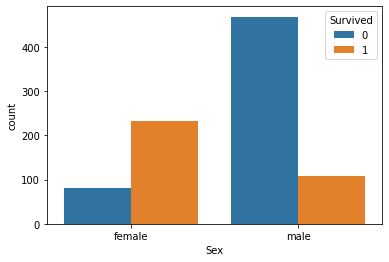

In [17]:
women = train_data.loc[train_data.Sex == "female"]['Survived']
rate_women = sum(women) / len(women)

men = train_data.loc[train_data.Sex == "male"]['Survived']
rate_men = sum(men) / len(men)

print("% of men who survived:", rate_men)
print("% of women who survived:", rate_women)

sns.countplot(x = 'Sex', data = train_data, hue = 'Survived')

**Survived ~ Ticket Class (Pclass)**

% of class 1 who survived: 0.6296296296296297
% of class 2 who survived: 0.47282608695652173
% of class 3 who survived: 0.24236252545824846


<AxesSubplot:xlabel='Pclass', ylabel='count'>

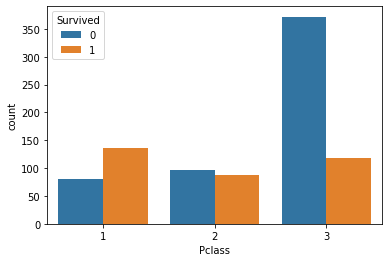

In [18]:
class1 = train_data.loc[train_data.Pclass == 1]['Survived']
rate_class1 = sum(class1) / len(class1)

class2 = train_data.loc[train_data.Pclass == 2]['Survived']
rate_class2 = sum(class2) / len(class2)

class3 = train_data.loc[train_data.Pclass == 3]['Survived']
rate_class3 = sum(class3) / len(class3)

print("% of class 1 who survived:", rate_class1)
print("% of class 2 who survived:", rate_class2)
print("% of class 3 who survived:", rate_class3)

sns.countplot(x = 'Pclass', data = train_data, hue = 'Survived')

**Survived ~ # of Parents/Children (Parch)**

% of passengers who have  0  of parents/children aboard the Titanic that survived: 0.34365781710914456
% of passengers who have  1  of parents/children aboard the Titanic that survived: 0.5508474576271186
% of passengers who have  2  of parents/children aboard the Titanic that survived: 0.5
% of passengers who have  5  of parents/children aboard the Titanic that survived: 0.2
% of passengers who have  3  of parents/children aboard the Titanic that survived: 0.6
% of passengers who have  4  of parents/children aboard the Titanic that survived: 0.0
% of passengers who have  6  of parents/children aboard the Titanic that survived: 0.0


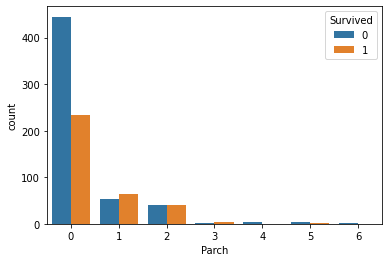

In [19]:
for i in train_data.Parch.unique():
    temp_survived = train_data.loc[train_data.Parch == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of passengers who have ", i, " of parents/children aboard the Titanic that survived:", rate)
    
sns.countplot(x = 'Parch', data = train_data, hue = 'Survived')
plt.legend(title = 'Survived', loc='upper right')


**Survived ~ # of Sibiling/Spouses (SibSp)**

% of passengers who have  1  of siblings/spouses aboard the Titanic that survived: 0.5358851674641149
% of passengers who have  0  of siblings/spouses aboard the Titanic that survived: 0.34539473684210525
% of passengers who have  3  of siblings/spouses aboard the Titanic that survived: 0.25
% of passengers who have  4  of siblings/spouses aboard the Titanic that survived: 0.16666666666666666
% of passengers who have  2  of siblings/spouses aboard the Titanic that survived: 0.4642857142857143
% of passengers who have  5  of siblings/spouses aboard the Titanic that survived: 0.0
% of passengers who have  8  of siblings/spouses aboard the Titanic that survived: 0.0


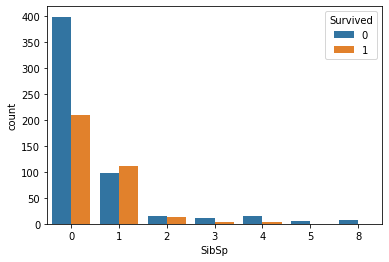

In [20]:
for i in train_data.SibSp.unique():
    temp_survived = train_data.loc[train_data.SibSp == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of passengers who have ", i, " of siblings/spouses aboard the Titanic that survived:", rate)
    

sns.countplot(x = 'SibSp', data = train_data, hue = 'Survived')
plt.legend(title = 'Survived', loc='upper right')

**Survived ~ Age**

% of Adults that survived: 0.36176066024759285
% of Infants that survived: 0.6666666666666666
% of Teens that survived: 0.4105263157894737
% of Kids that survived: 0.5128205128205128


<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

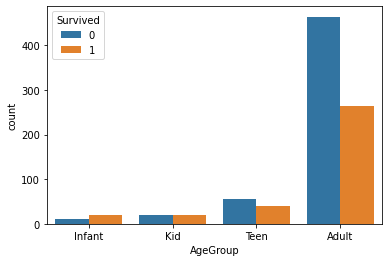

In [21]:
for i in train_data.AgeGroup.unique():
    temp_survived = train_data.loc[train_data.AgeGroup == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of", i + 's', "that survived:", rate)

sns.countplot(x = 'AgeGroup', data = train_data, hue = 'Survived')

###### The features- PassengerId, Name, Number of Ticket, Cabin, Embarked and Fare, are not affectingin in any way the chance to survive or not.

# **Model Building**

### Data Preparation
Before using the classification models, let's prepered our data:

In [22]:
X = train_data.loc[:, ("Sex_cat", "Pclass", "SibSp", "Parch", "Age")]
y = train_data["Survived"].values
X

,Sex_cat,Pclass,SibSp,Parch,Age
0,1,3,1,0,22.000000
1,0,1,1,0,38.000000
2,0,3,0,0,26.000000
3,0,1,1,0,35.000000
4,1,3,0,0,35.000000
...,...,...,...,...,...
886,1,2,0,0,27.000000
887,0,1,0,0,19.000000
888,0,3,1,2,29.699118
889,1,1,0,0,26.000000


In [23]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[ 0.73769513,  0.82737724,  0.43279337, -0.47367361, -0.5924806 ],
       [-1.35557354, -1.56610693,  0.43279337, -0.47367361,  0.63878901],
       [-1.35557354,  0.82737724, -0.4745452 , -0.47367361, -0.2846632 ],
       ...,
       [-1.35557354,  0.82737724,  0.43279337,  2.00893337,  0.        ],
       [ 0.73769513, -1.56610693, -0.4745452 , -0.47367361, -0.2846632 ],
       [ 0.73769513,  0.82737724, -0.4745452 , -0.47367361,  0.17706291]])

## **Model Selection**

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
models_accuracy_scores = {}

## **Logistic Regression**

In [26]:
from sklearn.linear_model import LogisticRegression
logistic_classifier = LogisticRegression(random_state=0)
logistic_accuracies = cross_val_score(logistic_classifier, X, y, cv = 10, scoring = 'accuracy')
logistic_score = logistic_accuracies.mean()
logistic_std = logistic_accuracies.std()
print(logistic_score, logistic_std)

0.7878526841448189 0.02553551899953366


In [27]:
models_accuracy_scores["Logistic Regression"] = [logistic_score, logistic_std]

## **K-NN**

In [28]:
# search for an optimal value of k for K-NN
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    scores = cross_val_score(knn, X, y, cv = 10, scoring = 'accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.7610362047440699, 0.8013982521847691, 0.8081647940074907, 0.8205243445692885, 0.8137827715355804, 0.810461922596754, 0.8104244694132333, 0.8059051186017477, 0.8058801498127341, 0.8047565543071162, 0.8092634207240949, 0.8081148564294633, 0.8081273408239701, 0.8024968789013732, 0.8024968789013733, 0.8024594257178528, 0.8035955056179775, 0.8069538077403247, 0.8170661672908863, 0.8136953807740325, 0.8193008739076154, 0.8170661672908863, 0.8181647940074905, 0.8170536828963796, 0.8204369538077403, 0.8226716604244693, 0.8193008739076154, 0.8181772784019975, 0.8170661672908863, 0.8204369538077405]


Text(0, 0.5, 'Cross-Validated Accuracy')

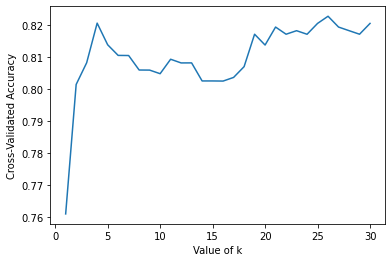

In [29]:
# plot the value of k for K-NN (x axis) versus the cross-validated accuracy (y axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validated Accuracy')

The optimal value of k is 27 with 0.786729 accuracy score

In [30]:
knn_classifier = KNeighborsClassifier(n_neighbors=26, metric='minkowski', p=2)
knn_accuracies = cross_val_score(knn_classifier, X, y, cv = 10, scoring = 'accuracy')
knn_score = knn_accuracies.mean()
knn_std = knn_accuracies.std()
print(knn_score)
models_accuracy_scores["K-NN"] = [knn_score, knn_std]

0.8226716604244693


## **SVM**

In [31]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', random_state=0)
svm_accuracies = cross_val_score(svm_classifier, X, y, cv = 10, scoring = 'accuracy')
svm_score = svm_accuracies.mean()
svm_std = svm_accuracies.std()
models_accuracy_scores["SVM"] = [svm_score, svm_std]

In [32]:
models_accuracy_scores

{'Logistic Regression': [0.7878526841448189, 0.02553551899953366],
 'K-NN': [0.8226716604244693, 0.03247897231498733],
 'SVM': [0.786729088639201, 0.028599350013463757]}

## **Naive Bayes**

In [33]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_accuracies = cross_val_score(nb_classifier, X, y, cv = 10, scoring = 'accuracy')
nb_score = nb_accuracies.mean()
nb_std = nb_accuracies.std()
models_accuracy_scores["Naive Bayes"] = [nb_score, nb_std]

In [34]:
nb_score

0.762059925093633

## **Random Forest**

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rf_accuracies = cross_val_score(rf_classifier, X, y, cv = 10, scoring = 'accuracy')
rf_score = rf_accuracies.mean()
rf_std = rf_accuracies.std()
models_accuracy_scores["Random forest"] = [rf_score, rf_std]
rf_score

0.7991760299625469

In [36]:
models_accuracy_scores

{'Logistic Regression': [0.7878526841448189, 0.02553551899953366],
 'K-NN': [0.8226716604244693, 0.03247897231498733],
 'SVM': [0.786729088639201, 0.028599350013463757],
 'Naive Bayes': [0.762059925093633, 0.028809289673386286],
 'Random forest': [0.7991760299625469, 0.03854942486782428]}

In [37]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [38]:
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
